# Notebook on maze experiment

### Import modules

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.func import vmap
from torch.nn import MSELoss
import torch.nn.functional as F
import torch.cuda.amp as amp
from torch.utils.data import DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler
from functools import wraps
from utils import *
from utils_maze import *
from model import *
from distributions import *

inter = 6

length = 300
criterion = MSELoss(reduction="sum")

dim=length//inter

device = "cuda" if torch.cuda.is_available() else "cpu" 
print(device)

setup()

cpu


### Setup data

It amounts to load and scale data.

In [2]:
scaler, Path_Loader, observations, Actions=setup_data(filename="maze2d-medium-sparse-v1.hdf5")

['actions', 'infos/goal', 'infos/qpos', 'infos/qvel', 'observations', 'rewards', 'terminals', 'timeouts']
(2000000, 4)


### Sample and display

Sample from base and target distribution. And check their shapes.

In [3]:
x=target(n=1000, l=length, inter=inter, array=observations, device=device)

base = BaseDistribution(device = device)
print(x.shape)
base.sample(n=10, l=length//inter, actions=False).shape

torch.Size([1000, 1, 50, 2])


torch.Size([10, 1, 50, 2])

Shape of samples from base distribution is torch.Size([1000, 1, 50, 2])
Shape of samples from target distributions is torch.Size([1000, 1, 50, 2])


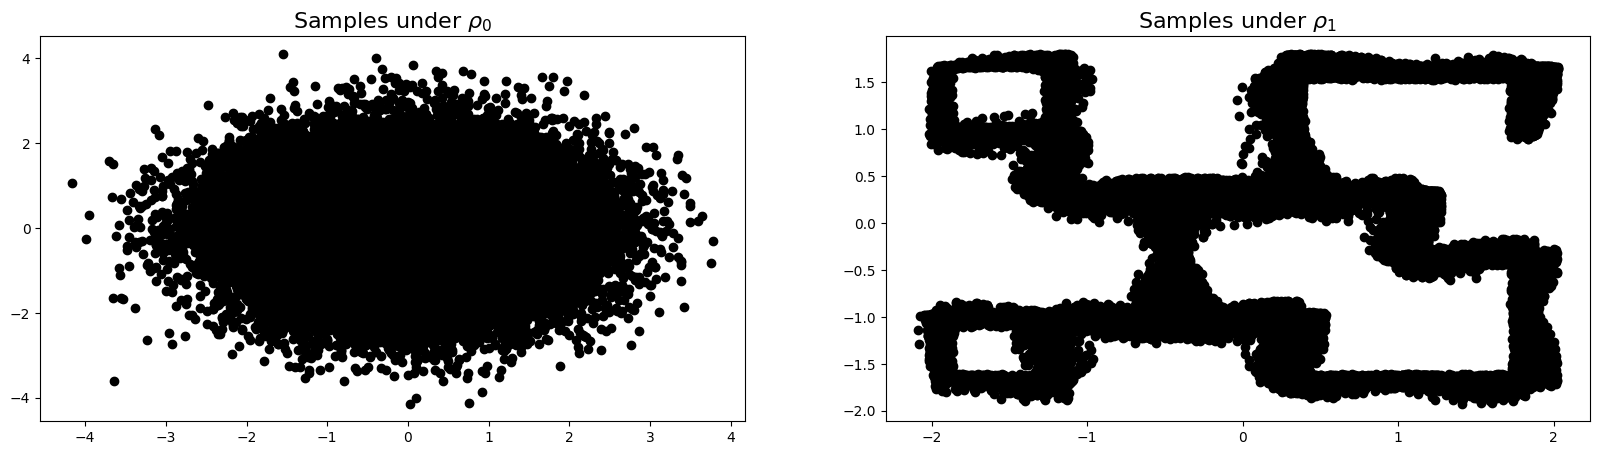

In [4]:
x0s = base.sample(n=1000, l=length//inter)
x1 = target(n=1000, l=length, inter=inter, array=observations)
print("Shape of samples from base distribution is", x0s.shape)
print("Shape of samples from target distributions is", x1.shape)
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax0.scatter(x0s[...,0].cpu(), x0s[..., 1].cpu(), color="black")
ax0.set_title(r"Samples under $\rho_0$", fontsize = 16)
ax1.scatter(x1[:,0,...,0].cpu(), x1[:,0,...,1].cpu(), color="black")
ax1.set_title(r"Samples under $\rho_1$", fontsize = 16)
plt.show()

## Interpolation between base and target distribution

 $\alpha$ should be the same for all dimensions of input space.

### Linear interpolation

$\alpha$ follows a linear scheme: $\alpha_t=1-t$ for $t \in [0, 1]$.

In [5]:
bs=10000 #batch size
list_alpha = torch.stack([torch.rand(length, device = device) for _ in range(bs)], axis = 0)
interpolant = Interpolant()

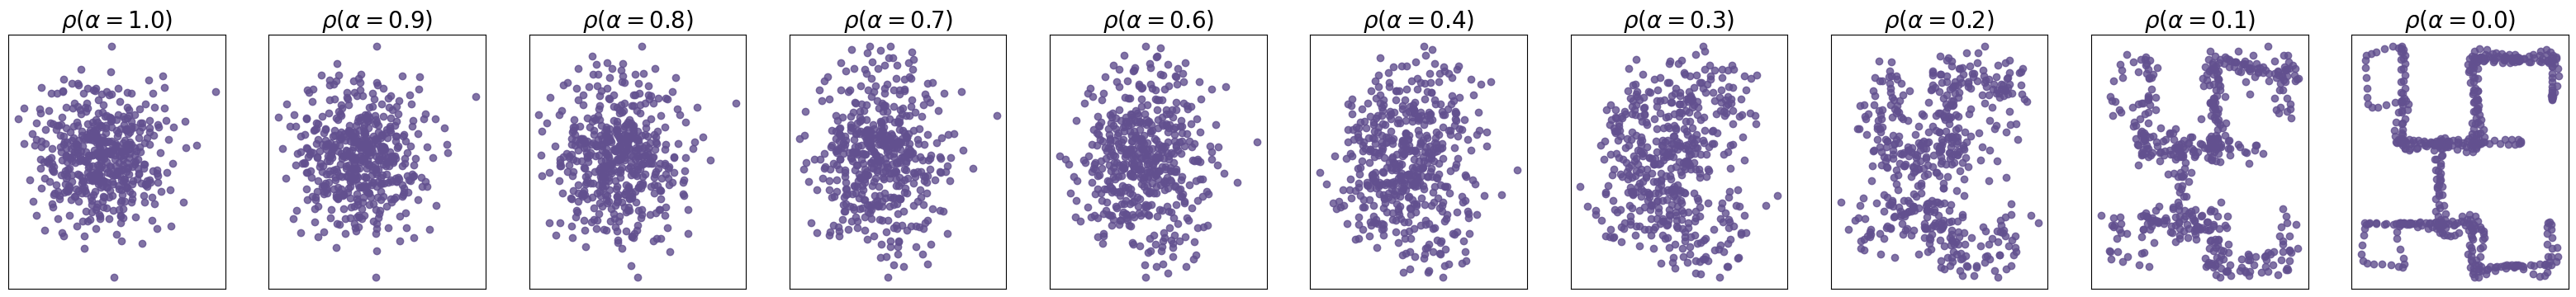

In [6]:
def manual_linear_interpolation(n:int=10, ncol:int=10, color:str='#62508f'):

    ts=torch.linspace(1., 0, ncol, device = device)
    Alpha=torch.cat((ts[:,None],)*(length // inter), axis = 1)

    fig, axes = plt.subplots(1, ncol, figsize=(ncol*4,4))

    x0s=base.sample(n=n, l=length//inter).to(device)
    x1=target(n, l=length, inter=inter, array=observations, device=device)
    for i in range(ncol):
        alpha = Alpha[None, i].repeat(n, 1) #Repeat for each path
        xts = interpolant.xt(x0s, x1, alpha)

        axes[i].scatter(xts.cpu()[...,0], xts.cpu()[..., 1], alpha = 0.8, c = color) # plot samples x_t \sim \rho_t

        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(r'$\rho(\alpha = %.1f)$' % alpha[0, 0].item(), fontsize = 20, weight='bold')

        if i !=0:
            axes[i].set_yticks([])
    plt.show()
manual_linear_interpolation()

### Cosine-planning

This time, take $\alpha_t=\cos(\frac{t+\epsilon}{(1+\epsilon)\pi/2})$, with $t$ uniformly sampled on $[0,1]$. With this scheme, the interpolation is more uniformly spread out between $x_0$ and $x_1$.

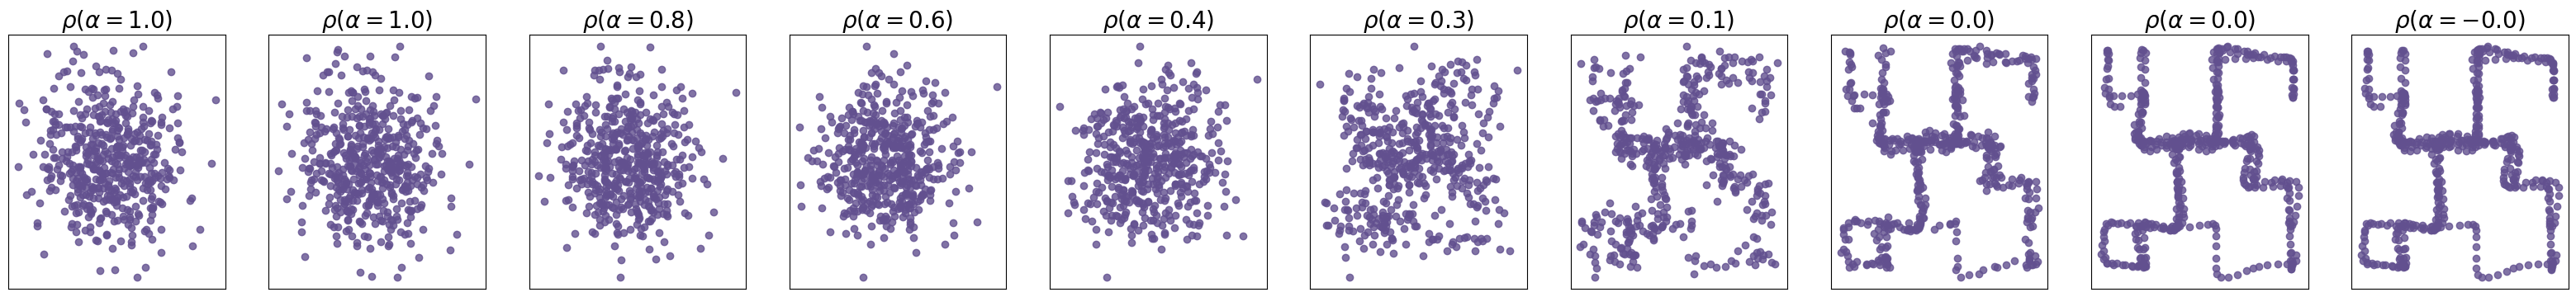

In [7]:
def manual_cosine_interpolation(n:int=10, ncol:int=10, color:str='#62508f'):

    ts=torch.linspace(0, 1, ncol, device = device)
    Alpha=torch.cat((ts[:,None],)*(length // inter), axis = 1)

    fig, axes = plt.subplots(1, ncol, figsize=(ncol*4,4))
    eps=0

    x0s=base.sample(n=n, l=length//inter).to(device)
    x1=target(n=n, l=length, inter=inter, array=observations, device = device)

    for i in range(ncol):
        alpha  = torch.cos((Alpha[None, i].repeat(n, 1) + eps)/(1 + eps)*np.pi/2)**3
        xts = interpolant.xt(x0s, x1, alpha)

        axes[i].scatter(xts.cpu()[...,0], xts.cpu()[..., 1], alpha = 0.8, c = color) # plot samples x_t \sim \rho_t

        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(r'$\rho(\alpha = %.1f)$' % alpha[0, 0].item(), fontsize = 20, weight='bold')

        if i !=0:
            axes[i].set_yticks([])
    plt.show()
manual_cosine_interpolation()

## Instantiate the U-Net neural network

Make sure the pipeline is well defined.

X should have only one channel here.

In [8]:
b =  VelocityFieldTS(init_features=dim, device=device).to(device)

bs = 10 ## simple test batch size

X = target(n=bs, array=observations, l=length, inter=inter, device=device)
Alpha = torch.rand(bs, dim).to(device)

print("Shape of data is", X.shape)
print("Shape of interpolant is", Alpha.shape)

out = b.forward(X, Alpha) ## should output something of shape [bs, length]
print("U-Net output's shape is", out.shape)

Shape of data is torch.Size([10, 1, 50, 2])
Shape of interpolant is torch.Size([10, 50])
U-Net output's shape is torch.Size([10, 1, 50, 2])


### Test it works fine

Declare loss function, and ensure it works properly.

In [9]:
def loss_fn(b: VelocityFieldTS, interpolant: Interpolant, x0: Tensor, x1: Tensor, alpha: Tensor):
    """
    Interpolant loss function for a single datapoint of (x0, x1, alpha).
    """
    It   = interpolant.xt(x0, x1, alpha)
    dtIt = interpolant.dtxt(x0, x1)
    bt          = b.forward(It, alpha)
    loss        = criterion(bt.squeeze(), dtIt.squeeze())/len(x0)
    return loss

test_Unet(n=10, length=length, inter=inter, array=observations)

197.88348388671875

## Training the Neural Network

In [10]:
Index = torch.linspace(0, 1, 1000)
def train_step(b: VelocityFieldTS, Dataloader: DataLoader, interpolant: Interpolant, opt: torch.optim, sched: torch.optim.lr_scheduler, N: int, Scaler, eval_ = False):
    """
    N (int): batch size.
    eval_ (bool): Eval the dataset.
    """
    global inter
    b.train()
    
    opt.zero_grad()
    x1s = target(n=N, l=length, inter=inter, array=observations, device=device) #Sample from observations
    x0s = base.sample(n=N, l=length // inter) #Sample base distribution
    
    # alpha = torch.rand(N, 1).to(device).repeat(1, length) #For training on diagonal hypercube
    alpha = torch.rand(N, length//inter).to(device)
    
    with amp.autocast():
        loss_train = loss_fn(b, interpolant, x0s, x1s, alpha).mean()
    # perform backprop
    Scaler.scale(loss_train).backward() #Scale the loss
    torch.nn.utils.clip_grad_norm_(b.parameters(), max_norm = 10) #Clip the norm of the gradients
    Scaler.step(opt) #Update the parameters' gradient
    Scaler.update()
    sched.step()
    
    if eval_:
        b.eval()
        x0s_eval = base.sample(n=N//2, l=length//inter)
        x1s_eval = target(n=N, l=length, inter=inter, array=observations, device=device) #Sample from observations
        alpha_eval = torch.rand(N//2, 1).to(device).repeat(1, length)
        #Evaluate loss on validation dataset
        loss_eval = loss_fn(b, interpolant, x0s_eval, x1s_eval, alpha_eval).mean()
    else:
        loss_eval = torch.tensor(torch.nan)
    res = {
            'loss': loss_train.detach(),
            'loss_eval': loss_eval.detach()
        }
    return res


def train(b:VelocityFieldTS, warm_up:str=False, path:str="weight_CONV_MAZE_L100.pth"):
    interpolant = Interpolant()
    if warm_up:
        b.load_state_dict(torch.load(path))
    print("This model has", sum(p.numel() for p in b.parameters()), "parameters.")
    lr = 1e-3
    weight_decay = 0.1
    n_opt = 8000
    Scaler = amp.GradScaler()
    opt = torch.optim.AdamW(b.parameters(), lr = lr, weight_decay = weight_decay)
    sched = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=.999)
    
    losses = []
    losses_eval = []
    from tqdm import tqdm
    pbar = tqdm(range(n_opt))
    for i in pbar:
        
        res = train_step(b, Path_Loader, interpolant, opt, sched, bs, Scaler, eval_ = eval_)

        loss = res['loss'].to('cpu').detach().numpy().mean()
        loss_v = res['loss_eval'].to('cpu').detach().numpy().mean()
        
        losses.append(loss)
        losses_eval.append(loss_v)
        pbar.set_description(f'Loss: {loss:.4f}, Loss eval: {loss_v: .4f}')

        if i%100==0:
            torch.save(b.state_dict(), path)

    plt.plot(losses, label="Training Loss")
    # if eval_:
    #     plt.plot(losses_eval, label="Evaluation Loss")
    # plt.legend()

#### Running the Training

We are now ready to train our model. Let's build a loop that runs for `n_opt` steps and store the loss over time.

Create a Path loader for training.

In [11]:
chunk = len(observations)//(length//inter)
obs = np.split(observations, chunk, axis=0)
bs = 3000 #batch size
Path_Loader = DataLoader(dataset=obs, batch_size=bs, shuffle=True)

In [12]:
%%time
Load = True
warm_up = False
eval_ = False

if not Load:
    b = VelocityFieldTS(init_features=length//inter, device=device)
    train(b=b, warm_up=warm_up, path="weight_CONV_MAZE_L50.pth")
    
if Load:
    b.load_state_dict(torch.load("weight_CONV_MAZE_L50.pth", map_location=torch.device("cpu")))
    print("This model has", sum(p.numel() for p in b.parameters()), "parameters.")
    b.eval()

<timed exec>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


This model has 109941145 parameters.
CPU times: user 569 ms, sys: 314 ms, total: 883 ms
Wall time: 404 ms


In [18]:
interpolant = Interpolant()

class SDE:
    def __init__(self, b, interpolant, eps, n_step, Alpha = None, mask = None, device: str = device):
        self.b           = b
        self.interpolant = interpolant
        self.n_step      = n_step
        if Alpha is None:
            self.alpha       = torch.stack((torch.linspace(1.0,0.0, n_step + 1, device = device),)*(length//inter), axis = 1)
        else:
            self.alpha = Alpha

        if mask is None:
            self.mask = torch.ones(length//inter*2, device = device).reshape(length//inter, 2)
        else:
            self.mask = mask
            if mask.device != device:
                self.mask = mask.to(device)

        self.dt          = 1/n_step
        self.eps         = eps
        self.sqrtepsdt   = torch.sqrt(torch.tensor(2.0)*self.eps*self.dt)

        self.device = device

    def step(self, x, alpha):
        alpha_t = self.interpolant.alpha(alpha).reshape(-1, 1, length//inter, 1)
        gen = self.b(x, alpha)
        alpha_t = alpha_t.repeat(1, 1, 1, 2).to(device)
        return x + (-gen*self.dt + torch.sqrt(alpha_t)*self.sqrtepsdt*torch.randn(x.size(), device = self.device) - self.eps*(x + (1 - alpha_t)*gen)*self.dt)*self.mask

    def solve(self, x_init: torch.Tensor) -> torch.Tensor:
        self.b.eval()
        bs = x_init.shape[0]
        xs = torch.zeros((self.n_step, *x_init.shape), device = device)
        x = x_init
        for i, alpha in enumerate(self.alpha[:-1]):
            alpha = alpha.repeat(len(x), 1).to(device) #Repeat for each batch size
            x = self.step(x, alpha)
            xs[i] = x
        return xs

eps = torch.tensor(0.7)
sde = SDE(b, interpolant, eps = eps, n_step = 80, device = device)
n_bs = 5
x0s= base.sample(n=n_bs, l=length//inter)
x0s = x0s.to(device)
x_init = x0s.clone().detach().to(device)  # Assume this is your forward-solved endpoint
x_final = sde.solve(x_init)
print(x_final.device)
x1s = x_final[-1].cpu().detach().numpy()  # This should give you the noise

cpu


### Full path generation without constraint

The whole path is generated at once. The only expectation is to not have a single point within a wall case.

torch.Size([1, 1, 50, 2])
Done.
The number of points within a wall case is 0


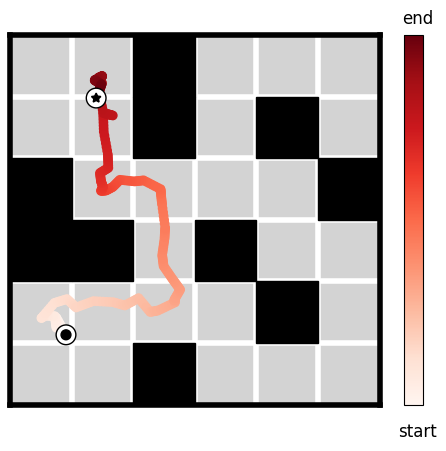

In [14]:
def full_path_generation(b: VelocityFieldTS, n_step: int=80, eps:float=.7, device=device, N:int=length//inter, scaler=scaler):
    sde  = SDE(b, interpolant, n_step = 80, device = device, eps = .7)
    batch_size=1
    x0s = base.sample(n=batch_size, l=length//inter, actions=False)

    x0s = x0s.to(device)
    x_init = x0s.clone().detach()  # Assume this is your forward-solved endpoint
    print(x_init.shape)
    # x_init = ode.solve(x_init)
    x_final = sde.solve(x_init).squeeze(2)
    x1s = x_final[-1].cpu().detach().numpy()  # This should give you the noise

    x1s = interpolate(x1s)
    plot_maze(obs=x1s, scaler=scaler)
    print("The number of points within a wall case is", count_in_wall(x1s))
full_path_generation(b)

### Generation on conditioning firsts and lasts points

The path is here generated connecting two predetermined endpoints. The pathway's length should be adapted accordingly. You still need to specify the index of the path's end point.

Done.


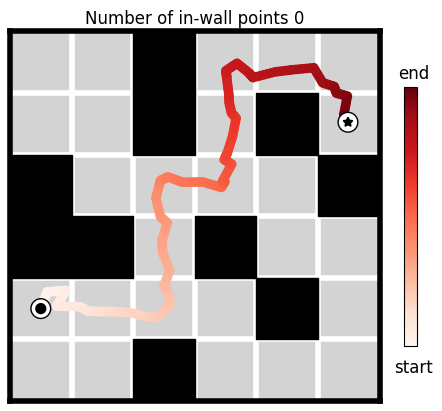

In [ ]:
#Take a random index to impose a number of point in the path. In practice, it must be CHOSEN WISELY.
idx = np.random.randint(low=7, high=50)
idx = -1

#Load in the set of start and end point, already normalized
with open("Starting_Points.pth", mode="rb") as f:
    points = pkl.load(f)

#Choose a pair or start and end point.
idxx=4
start_point = torch.tensor(points[idxx, 0], device=device)
end_point = torch.tensor(points[idxx, 1], device=device)

def shortest_path(start_point: np.ndarray, end_point: np.ndarray, idx: int=-1):
    
    Alpha = torch.stack((torch.linspace(1.0,0.0, 80 + 1, device = device),)*((length//inter)), axis = 1)
    Alpha[:,idx] = 0
    Alpha[:,0] = 0
    
    mask = torch.ones((length//inter), device = device)
    mask[idx] = 0
    mask[0] = 0
    mask = torch.concatenate((mask[:,np.newaxis], mask[:,np.newaxis]), axis = 1)
    
    sde  = SDE(b, interpolant, n_step = 80, device = device, eps = .7, Alpha=Alpha, mask=mask)
    n_bs = 1
    
    x0s = base.sample(n=n_bs, l=length//inter)
    x0s = x0s.to(device)
    x_init = x0s.clone().detach()  # Assume this is your forward-solved endpoint
    x_init[:, 0, idx], x_init[:, 0, 0] = torch.tensor(end_point, device=device), torch.tensor(start_point, device=device)
    
    x_final = sde.solve(x_init).squeeze(2) #Remove the useless channel axis
    x1s = x_final[-1].cpu().detach().numpy() #Keep the last time step
    x1s = interpolate(x1s)
    plot_maze(obs=x1s, scaler=scaler, title="Number of in-wall points {}".format(count_in_wall(x1s)))

shortest_path(start_point, end_point)

### Generate a path with shorter length

/tmp/ipykernel_198800/2929917863.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  start_point = torch.tensor(start_point, device=device)
/tmp/ipykernel_198800/2929917863.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  end_point = torch.tensor(end_point, device=device)


Done.


<Axes: >

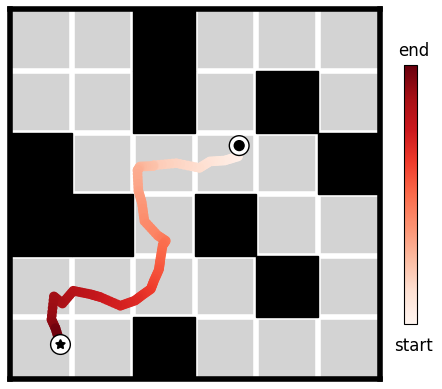

In [54]:
#Take a random index to impose a number of point in the path

idx = np.random.randint(low=7, high=50)
idx = 30

#Load in the set of start and end point, already normalized
with open("Starting_Points", mode="rb") as f:
    points = pkl.load(f)

#Choose a pair or start and end point.
idxx=0
start_point = torch.tensor(points[idxx, 0], device=device)
end_point = torch.tensor(points[idxx, 1], device=device)

# start_point = scaler.transform(np.array(([[0.47704682 +.4, 0.6697078 +.4]])))
# end_point = scaler.transform(np.array([[6.217887 + .2, 6.217159 + .2]]))

start_point = torch.tensor(start_point, device=device)
end_point = torch.tensor(end_point, device=device)

Alpha = torch.stack((torch.linspace(1.0,0.0, 80 + 1, device = device),)*((length//inter)), axis = 1)
Alpha[:,idx] = 0
Alpha[:,0] = 0

mask = torch.ones((length//inter), device = device)
mask[idx] = 0
mask[0] = 0
mask = torch.concatenate((mask[:,np.newaxis], mask[:,np.newaxis]), axis = 1)

sde  = SDE(b, interpolant, n_step = 80, device = device, eps = .7, Alpha=Alpha, mask=mask)
n_bs = 1

x0s = base.sample(n=n_bs, l=length//inter)
x0s = x0s.to(device)
x_init = x0s.clone().detach()  # Assume this is your forward-solved endpoint
x_init[:, 0, idx], x_init[:, 0, 0] = end_point, start_point

x_final = sde.solve(x_init).squeeze(2) #Remove the channel axis
x1s = x_final[-1].cpu().detach().numpy() #Keep the last time step
x1s = x1s[:, :idx+1]
x1s = interpolate(x1s, length=(idx+1)*inter)
plot_maze(obs=x1s, scaler=scaler)

Now comes the question to determine the adequate path length between the start and end point. I decide to adopt a small heuristic. I start with very small length and generate the path while applying the constraints. If at least one point lies in a wall maze, I start again with a longer path, until all points are valid. 

---

### Add a constraint on the path.

With multitask stochastic interpolation, you are not limited to choosing only the start and end points of your path. You can also specify a pre-defined point along the path and the generated result will still join the start and end points together. You can find two examples on the website.

Generating a path requires calculating the length between every fixed points; it is therefore two times as costly than simple generation here. 

The generation is more unstable when there is a single constraint in the middle of the path. To stabilise the generation, I add more points than are returned by the `find_length` function.

In [43]:
def find_length(start_point: np.ndarray, end_point: np.ndarray, device=device, scaler=None):
    """
    Determine the most adequate path length. First, choose a length and run path generation. If at least one point crosses a black box, 
    you generate a path with more points, until no point intersects any black box.
    Only one path at a time, there is no for loop or vectorization.
    """
    global length, inter
    Time = [5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
    
    if scaler is not None:
        start_point=scaler.transform(start_point[None,...])
        end_point=scaler.transform(end_point[None,...])
    
    #Convert to tensor
    start_point, end_point = torch.tensor(start_point, device=device), torch.tensor(end_point, device=device)
    
    for i, idx in enumerate(Time):

        Alpha = torch.stack((torch.linspace(1.0,0.0, 80 + 1, device = device),)*((length//inter)), axis = 1)
        Alpha[:,idx] = 0
        Alpha[:,0] = 0

        mask = torch.ones((length//inter), device = device)
        mask[idx] = 0
        mask[0] = 0
        mask = torch.concatenate((mask[:,np.newaxis], mask[:,np.newaxis]), axis = 1)

        sde  = SDE(b, interpolant, n_step = 80, device = device, eps = .7, Alpha=Alpha, mask=mask)
        n_bs = 1 #Only one sample, no need to do more.

        x0s = base.sample(n=n_bs, l=length//inter)
        x0s = x0s.to(device)
        x_init = x0s.clone().detach()  # Assume this is your forward-solved endpoint
        x_init[:, 0, idx], x_init[:, 0, 0] = end_point, start_point

        x_final = sde.solve(x_init).squeeze(2) #Remove the channel axis
        x1s = x_final[-1].cpu().detach().numpy() #Keep the last time step
        x1s = x1s[:, :idx+1]
        x1s = interpolate(x1s, length=(idx+1)*inter)
        # Count the number of points in wall
        counter = count_in_wall(x1s, scaler=scaler)
        if not counter:
            # plot_maze(obs=x1s, scaler=scaler)
            if i==len(Time)-1:
                return Time[i]
            else:
                return Time[i+1]
        print(counter)

Done.
Done.


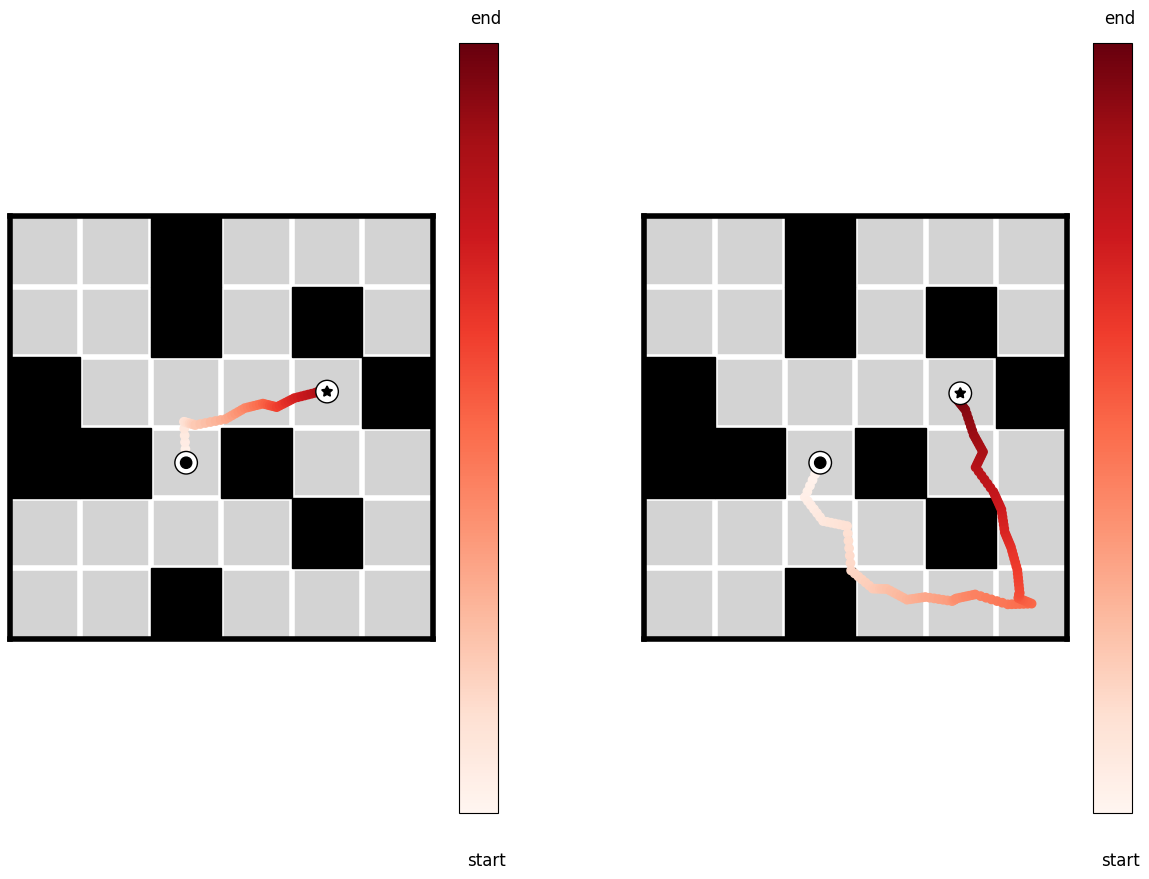

In [ ]:
def constrained_path(start_point: np.ndarray=None, end_point: np.ndarray=None):
    """
    Generate two paths between start point and end point.
    """
    fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    if start_point is None:
        start_point=np.array([3, 3])[None,...]
    if end_point is None:
        end_point=np.array([5, 4])[None,...]

    n_step=80 #Number of time-step in SDE numerical resolution

    start_point, end_point = scaler.transform(start_point), scaler.transform(end_point)

    center_point = scaler.transform(np.array([6, 1])[None,:])

    def initialize(constrained: bool=False):
        Alpha = torch.stack((torch.linspace(1.0,0.0, n_step + 1, device = device),)*((length//inter)), axis = 1)
        Alpha[:,0]=0

        mask = torch.ones((length//inter, 2), device = device)
        n_bs = 1

        if not constrained:
            len=find_length(start_point[0], end_point[0], device=device)

            x0s = base.sample(n=n_bs, l=length//inter)
            x0s = x0s.to(device)

            Alpha[:,len]=0

            mask[len]=0
            mask[0]=0

        if constrained:
            len_1=find_length(start_point.squeeze(0), center_point.squeeze(0), device=device)+3
            len_2=find_length(center_point.squeeze(0), end_point.squeeze(0), device=device)+3
            len=len_1+len_2 #Total length path

            Alpha[:,len]=0
            Alpha[:,len_1]=0

            mask[len]=0
            mask[0]=0
            mask[len_1]=0

            x0s = base.sample(n=n_bs, l=length//inter)
            x0s = x0s.to(device)

            x0s[:, 0, len_1]=torch.tensor(center_point, device=device)

        x_init = x0s.clone().detach()  # Assume this is your forward-solved endpoint
        x_init[:, 0, len], x_init[:, 0, 0] = torch.tensor(end_point, device=device), torch.tensor(start_point, device=device)
        sde=SDE(b, interpolant, eps, n_step=n_step, Alpha=Alpha, mask=mask, device=device)
        return x_init, len, sde

    ## Unconstrained path

    x_init, len, sde=initialize(constrained=False)
    x_final=sde.solve(x_init).squeeze(2) #Remove the channel axis
    x1s=x_final[-1].cpu().detach().numpy() #Keep the last time step
    x1s=x1s[:,:len+1]
    x1s=interpolate(x1s, length=len*inter)
    plot_maze(obs=x1s, scaler=scaler, fig_ax=(fig,ax[0]))

    ## Constrained path

    x_init, len, sde=initialize(constrained=True)
    x_final=sde.solve(x_init).squeeze(2) #Remove the channel axis
    x1s=x_final[-1].cpu().detach().numpy() #Keep the last time step
    x1s=x1s[:,:len+1]
    x1s=interpolate(x1s, length=len*inter)
    plot_maze(obs=x1s, scaler=scaler, fig_ax=(fig,ax[1]))

constrained_path()

### Smoothing out the path with d4rl

The original numerical experiment, as depicted in the [paper](https://arxiv.org/abs/2407.01392), smooth out the generated path via a RL environment. The README file details how to install/import the `d4rl` library.

I should add the U-Net weights and test the smooth-out function.

#### Pre-processing

Done.


array([[1.        , 1.        ],
       [1.00000002, 1.00000006],
       [1.00134829, 1.0023817 ],
       [1.00484631, 1.00713931],
       [1.01071764, 1.01426722],
       [1.01895663, 1.0237598 ],
       [1.02955763, 1.0356114 ],
       [1.04251502, 1.04981642],
       [1.05735133, 1.06636925],
       [1.07262506, 1.08526429],
       [1.08729707, 1.10649597],
       [1.10064562, 1.13005872],
       [1.11219634, 1.15594699],
       [1.12166509, 1.18415524],
       [1.13040746, 1.21467795],
       [1.139279  , 1.24750961],
       [1.14888484, 1.28264471],
       [1.15963388, 1.32007777],
       [1.17178315, 1.35980331],
       [1.18547391, 1.40181588],
       [1.19986361, 1.44611004],
       [1.21441028, 1.49268033],
       [1.22872345, 1.54152136],
       [1.24253215, 1.59157637],
       [1.25565848, 1.64084923],
       [1.26799615, 1.6880521 ],
       [1.27964237, 1.73276091],
       [1.29067381, 1.77498161],
       [1.30116338, 1.81472011],
       [1.31117908, 1.85198233],
       [1.

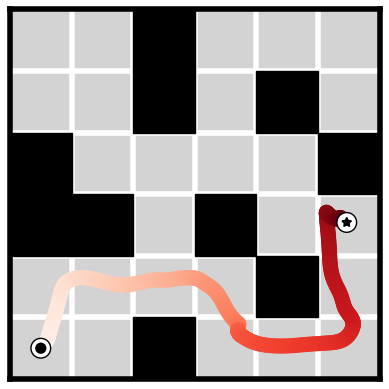

In [ ]:
def smooth_out(plan: torch.Tensor):
    """
    Smooth out a path using 'maze2d-medium-v1' gym environment.
    Args: 
        plan (Tensor). Pathway to smooth out. plan should NOT be normalized.
    Returns:
        A new pathway very similar to plan, but built by the gym environment.
    """
    import gym
    import d4rl

    envs = gym.make("maze2d-medium-v1", reward_type="dense")

    plan_t = torch.tensor(plan)

    envs.seed(0)

    start=envs.reset(qposvel=(plan[0], np.array([0, 0]))) #Initialize the env with the start point

    start=torch.tensor(start).float() #get the starting point

    obs = start

    goal = np.array([envs.get_target()]).squeeze() #Get the goal location

    goal = np.concatenate([goal, np.zeros(*goal.shape)], axis=-1) #Concatenate goal points with zero velocities.

    steps = 0
    episode_reward = np.zeros(1)
    episode_reward_if_stay = np.zeros(1)
    reached = np.zeros(1, dtype=bool)
    first_reach = np.zeros(1)

    # while not terminate and steps < episode_len:
    list_obs = start

    list_vel = list_obs[np.newaxis, 2:]
    list_obs = list_obs[np.newaxis, :2]

    terminate = False
    T=0

    open_loop_horizon=50

    dist = []

    while not terminate:

        for t in range(open_loop_horizon):

            if T + t >= len(plan_t):
                terminate=True
                break

            plan_vel = plan_t[T + t] - plan_t[T + t - 1] if T + t > 0 else plan_t[0] - start[:2]
            action = 12.5 * (plan_t[T + t] - obs[:2]) + 1.2 * (plan_vel - obs[2:])
            action = torch.clip(action, -1, 1).detach().cpu()
            obs, reward, done, info = envs.step(np.nan_to_num(action.numpy()))

            reached = np.logical_or(reached, reward >= 1.0)
            episode_reward += reward
            episode_reward_if_stay += np.where(~reached, reward, 1)
            first_reach += ~reached

            distance = np.linalg.norm(obs[:2] - goal[:2])
            dist += [distance]

            list_obs = np.append(list_obs, obs[np.newaxis, :2], axis=0)
            list_vel = np.append(list_vel, obs[np.newaxis, 2:], axis=0)

            steps += 1
        T += open_loop_horizon
    plot_maze_smooth(obs=list_obs, Start_point=plan[0], End_point=plan[-1])
    return list_obs

path=np.load('path_c.npy')
path=scaler.inverse_transform(path)
smooth_out(path)
